<a href="https://colab.research.google.com/github/Kimbaeda/youngwoo/blob/main/%ED%95%84%EC%82%AC_predict_future_sales_features_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\*\*\** 참고! 이 노트북은 리포스트입니다. 몇 번의 조립과 후처리 단계를 거쳐 리더보드의 상위 10개 안에 든 후에 원본을 개인 노트북으로 만들었습니다. Kaggle은 특정 버전의 노트북을 비공개로 만드는 것을 허용하지 않으며, 상위 10개 솔루션을 공유해야 한다고 생각하지 않습니다. \*\*\*

# Introduction

이 노트북은 Coursera 과정의 최종 프로젝트인 Predict Future Sales(http://www.coursera.org/learn/competitive-data-science/home/welcome)에 대한 예측 모델을 구성합니다. 이 작업은 러시아 회사 1C의 여러 소매점에서 다양한 품목의 월별 매출을 예측하는 것이다.

판다를 이용한 연습으로 몇 개월을 보냈기 때문에 어떤 부분은 일반적인 짧은 프로젝트 제출보다 좀 더 복잡합니다.

이 대회를 위해 제게 많은 것을 가르쳐 주고 볼 만한 가치가 있는 다른 아주 좋은 노트북들이 있습니다.<br>
https://www.kaggle.com/dlarionov/feature-engineering-xgboost<br>
https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3<br>
https://www.kaggle.com/deepdivelm/feature-engineering-lightgbm-exploring-performance<br>

첫째, 동일한 항목의 다른 버전(예: 동일한 게임 또는 음악 앨범의 다른 버전)을 참조할 가능성이 있는 매우 유사한 이름의 항목을 그룹화하는 항목 이름 그룹 기능이 있습니다. 둘째, 테스트 세트를 생성하는 방법을 활용하여 예측되는 한 달에 판매되는 품목이 예측되는 품목과 동일한 그룹(예: 동일한 범주, 동일한 이름 그룹)에 속하는 품목 수를 계산했다. 이 기능은 항목 이름 그룹 기능과 잘 결합되어 잘 팔릴 가능성이 있는 대규모 다중 형식 릴리스의 일부인 새 항목을 탐지합니다. 판매량이 많은 신제품을 찾는 것은 이 경쟁 모델에서 가장 어려운 과제 중 하나입니다(실제로 높은 점수를 받으려면 수동으로 수행해야 한다고 생각합니다).

# Data loading and preprocessing, utility function definition

## Imports and data loading

In [ ]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

노트북 전체에서 사용되는 몇 가지 유틸리티 기능.

In [ ]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

Load the provided data.

In [ ]:
# date path
data_path = 'C:/Users/User/0_Project/kaggle/competitive-data-science-predict-future-sales/'

items = pd.read_csv(data_path + 'items.csv')
shops = pd.read_csv(data_path + 'shops.csv')
train = pd.read_csv(data_path + 'sales_train.csv')
test = pd.read_csv(data_path + 'test.csv')

날짜 열을 datetime dtype으로 변환하여 날짜 시간 작업을 사용하도록 설정합니다.

In [ ]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

The training dataframe is cleaned with standard steps  


In [ ]:
# Merge some duplicate shops
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# Drop training items with extreme or negative prices or sales counts
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

## Preprocessing

테스트 데이터는 테스트 달에 판매를 등록한 상점 및 품목의 가능한 모든 조합(데카르트 제품)이며, 목표는 이러한 각각의 상점 항목 조합에 대해 이루어진 총 달의 판매량이다. 여기서 교육 데이터 기간의 매달 이 구조를 복제하는 교육 매트릭스가 만들어집니다. 테스트 항목은 테스트 기간 동안 기능을 생성할 수 있도록 교육 데이터 끝에 연결됩니다.

In [ ]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [ ]:
matrix = create_testlike_train(train, test)
del(test)

reduce_mem_usage 기능은 메모리 사용량을 줄이기 위해 데이터 유형을 다운캐스트하며, 이는 Kaggle 노트북의 메모리 오버플로 오류를 방지하기 위해 필요합니다.

In [ ]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.44 MB
Memory usage after optimization is: 152.04 MB
Decreased by 62.5%


## Feature engineering  
이 섹션에서는 예측 변수 특성 열이 생성되어 행렬에 추가됩니다.

# Item name groups with fuzzywuzzy

항목 테이블의 항목은 item_name 필드에 따라 알파벳 순서로 정렬되므로 유사한 항목이 일반적으로 서로 옆에 나열됩니다. 예를 들어 아래 표의 처음 두 항목은 두 개의 서로 다른 콘솔에 대해 동일한 게임 "퓨즈"를 사용하고, 이어서 동일한 인터넷 보안 프로그램에 대해 두 개의 서로 다른 라이센스 옵션을 사용합니다. 이 순서를 사용하여 관련 항목을 그룹화할 수 있습니다.

In [ ]:
items.query("item_id>3564").head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


다음 셀은 항목을 순차적으로 루핑하고 패키지 fuzzywuzzy(https://github.com/seatgeek/fuzzywuzzy),를 사용하여 인접 항목의 이름의 유사성을 측정하고 일치 값이 임계값을 초과할 경우 항목을 동일한 그룹에 할당하는 방식으로 유사한 항목을 그룹화합니다.

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import re

from fuzzywuzzy import fuzz


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Music artist / first word of item name  

이 기능은 아티스트 이름에 따라 음악 항목을 그룹으로 할당하며, 아티스트 이름을 나타내는 데 사용되는 3가지 일반적인 패턴(모두 대문자로, 릴리스 제목과 두 개의 공백으로 구분되거나 점 공백(.)으로 구분됨)에 따라 정규 표현식으로 항목 이름에서 추출됩니다.
비음악 카테고리의 경우 항목 이름의 첫 번째 단어에 따라 항목이 그룹화됩니다.

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords


def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

# Item name length as a feature
item_name 필드의 이름은 놀라울 정도로 예측 가능한데, 유사한 항목의 길이가 유사한 경우가 많기 때문일 수 있습니다. 이는 종종 항목 간의 유사성을 모호하게 하는 릴리스 형식에 대한 정보를 포함하는 특수 문자 및 괄호 용어의 원시 항목 이름과 정리된 이름 모두에서 기록됩니다.

In [ ]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [ ]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


# Time features
일별 및 월별 해상도 시간 기능은 교육 데이터 프레임에서 생성됩니다(예: 각 항목의 최초 및 마지막 판매 이후 일수).

각 항목의 첫 번째 판매 이후 시간은 평균 일일 판매 기능("항목_cnt_day_avg")을 생성하는 데에도 사용되는데, 이는 한 달 미만이기 때문에 전 달 동안 구매할 수 없었던 품목의 판매 수를 수정하는 데 유용할 수 있다.

In [ ]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # Month id feature
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [ ]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


# Price features  

해당 제품이 판매된 마지막 달의 가격 및 동일한 범주의 다른 품목에 상대적인 가격.

In [ ]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [ ]:
matrix = add_price_features(matrix, train)
del(train)

# Item category features  
데이터와 함께 제공된 항목 범주 외에도 supercategory(예: "games", "music")와 platform(예: "PS4, "mp3")의 두 가지 추가 범주 그룹도 수동으로 정의했습니다.

In [ ]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [ ]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

# Shop and item category clustering

상점 및 품목 범주는 판매 프로필에 따라 클러스터로 그룹화됩니다.
다음 함수는 상점 및 품목 카테고리의 주성분 분석 분해 및 군집화 결과를 수행하고 표시합니다.

각 PCA 치수에 의해 설명되는 항목 간의 차이를 설명하고, 개별 항목은 PCA 치수에 대한 점수에 따라 그리고 클러스터 할당에 따라 색상으로 표시됩니다.

클러스터 번호 매개 변수의 다양한 값에 대한 실루엣 점수(클러스터 품질 메트릭)도 표시됩니다. 이 그림은 군집의 수를 결정하는 데 사용되었습니다.

상점 및 품목 범주 모두에서 80% 이상의 차이가 1차원에서 발생하며, 이는 차이가 주로 비율이 아닌 규모임을 나타낸다. 항목 성분 점수 그림은 군집화가 주로 대부분의 항목을 포함하는 대규모 군집과 이상치 항목을 포함하는 일부 군집임을 보여 줍니다.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

품목 카테고리는 해당 연도의 평균 매출에 따라 군집화됩니다. 주성분 그림은 이 점에서 3개 범주가 특이치임을 보여줍니다.

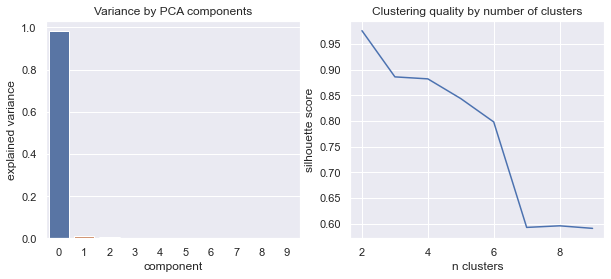

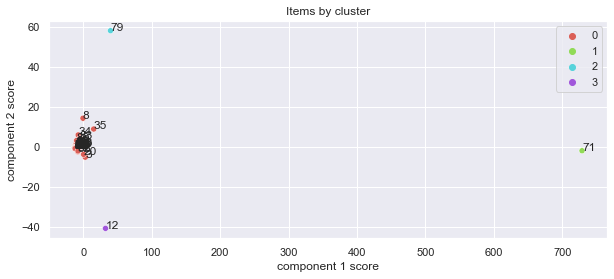

In [ ]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

상점들은 각 상품 카테고리의 매출 합계를 기준으로 군집화되어 있다. 주요 구성 요소 그림에 따르면 상점 31은 판매량 때문에 특이점이 되는 등 주로 판매 규모에서 차이가 납니다. 상점 12와 55는 서로 다른(online only) 품목을 판매하므로 직교 차원의 특이치입니다.

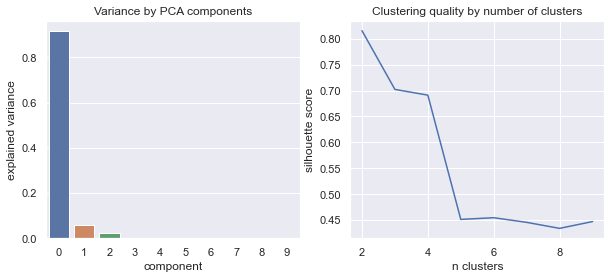

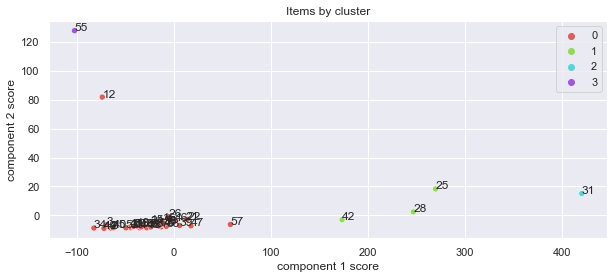

In [ ]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

# Number of unique item features

이러한 기능은 그룹 기능 또는 기능 집합의 동일한 값을 공유하는 고유 항목의 수(예: 동일한 범주의 새 항목 수)를 계산합니다.

이는 데이터 유출 기능의 일종으로 간주될 수 있는데, 이는 각 항목이 예측되는 달의 판매를 기록했는지 여부에 따라 결정되기 때문입니다(예: 미리 알려지지 않음).

In [ ]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [ ]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Percentage change in an aggregate feature  
이는 pasdas의 pct_change 방법을 사용하여 특정 시간 간격(예: 지난 2개월 동안의 품목 평균 판매 증가/감소) 동안 특정 그룹에 대한 평균 판매 카운트의 비례적 변화를 계산한다.

In [ ]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [ ]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [ ]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Windowed aggregates

특정 윈도우를 통해 통합된 기능을 통해 노이즈를 줄일 수 있습니다. 이용 가능한 창은 확장(즉, 모든 이전 시점), 롤링(즉, 동일하게 가중된 시점의 고정된 수), 지수 가중 평균이다.


특징명 참고사항 : 패턴 grouping - aggregate features aggreg - aggregation function < - < window type >에 따라 자동으로 설정되며, 여기서 < window type >은 square rolling 창에 대한 "rolling - < 창 집계기능 > - window aggregation function in months in - aggregation funths" 중 하나입니다.egation function ""은 창을 확장하는 데 사용되며, "ewm_hl - < 반감기 for는 지수 가중 평균에 적용되며 모두 밑줄로 연결됩니다.

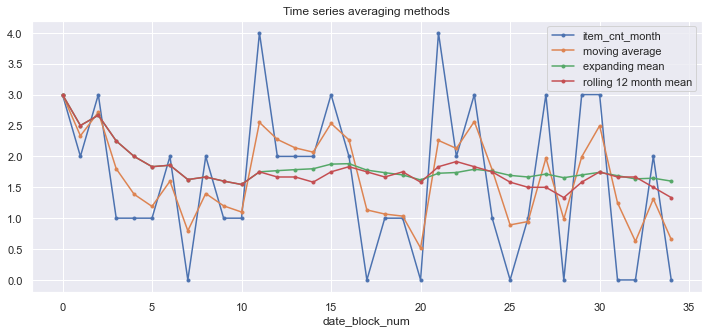

In [ ]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [ ]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

rolling mean features를 생성합니다. 여기에서 그룹화 기능과 창 유형의 조합은 많은 기능을 생성한 다음 sickit-learn RFECV 기능으로 가지치기함으로써 선택되었습니다.

In [ ]:
pd.__version__

'1.2.4'

In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "sh

In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

The following code block calculates windowed mean sales features with day resolution accuracy

In [ ]:
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="rolling",
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="expanding",
    reshape_source=False,
)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = matrix[
    "item_id_item_cnt_month_sum_expanding_sum"
] / matrix[["first_item_sale_days"]].min(axis=1)
matrix["shop_id_item_id_day_mean_win_12"] = matrix[
    "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


Revenue features

In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="item_revenue_month",
    dtype="float32",
)

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"


Windowed mean unique item features and ratio of new items in category with mean over the previous year

In [ ]:
matrix = add_rolling_stats(
    matrix,
    ["item_category_id"],
    argfeat="new_items_cat",
    window=12,
    reshape_source=True,
    lag_offset=1,
)
matrix = add_rolling_stats(
    matrix,
    ["item_name_group"],
    argfeat="name_group_new_unique_month",
    window=12,
    reshape_source=True,
    lag_offset=1,
)

matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"]
    / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [ ]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings  
이전 달의 동일한 상점-항목 조합에 대한 값

In [ ]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [ ]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Lag features created


## Mean encodings
범주형 특성의 각 수준 또는 범주형 특성의 조합에 대한 대상 특성의 평균 또는 합계 값, 지연됨

In [ ]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [ ]:
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_id_item_cnt_day_avg_mean_lag_1
Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1


Ratios between lag 1 sales and rolling 12 month means, to capture decreases from previous means

In [ ]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"]
    / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)

In [ ]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint.pkl")
print("Saved matrixcheckpoint")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint
Mean encoding features created


이제 다른 기능을 생성하는 데 사용된 일부 열을 폐기할 수 있습니다.

In [ ]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "artist_name_or_first_word",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "category_cluster",
    "shop_cluster",
    "new_items_cat",
    "shop_id_item_id_day_mean_win_12",
    "item_id_item_cnt_month_mean_rolling_mean_win_12",
]
matrix = matrix.drop(columns=surplus_columns)

# Predictive words in item_name

One-hot features are made for words in the item_name field that are predictive of item sales.  

To select *k* word features from the 1000's of words found in item names, words are discarded if they are not in the names of a threshold number of items, or are not in the names of new items in the test or validation months. Remaining words are then selected by the scikit-learn SelectKBest function according to their correlation with the target.

In [ ]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33):
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)
        st = re.sub(r"\s{2,}", " ", st)
        st = st.lower().strip()
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords)
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # Made the word counts binary
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

In [ ]:
items = pd.read_csv(data_path + 'items.csv')
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


The final feature frame is saved and the notebook kernel is reset to free up memory for LightGBM.

In [ ]:
gc.collect()
matrix.to_pickle("checkpoint_final.pkl")
print("All features generated, dataframe saved")

All features generated, dataframe saved


In [ ]:
%reset -f

# Model fitting

In [ ]:
import pandas as pd
import numpy as np

The feature frame is loaded and the target is clipped to match the test items

In [ ]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)

Split train and validation sets from the feature matrix, month 33 used as validation set

In [ ]:
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting


valid = matrix.drop(columns=dropcols).loc[matrix.date_block_num == 33, :]
train = matrix.drop(columns=dropcols).loc[matrix.date_block_num < 33, :]
train = train[train.date_block_num >= 2]
test = matrix.drop(columns=dropcols).loc[matrix.date_block_num==34, :]
X_test = test.drop(columns="item_cnt_month")
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
del matrix

Define a function to fit and return a lightgbm regressor with or without early stopping

In [ ]:
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm


def fit_booster(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    params=None,
    test_run=False,
    categoricals=[],
    dropcols=[],
    early_stopping=True,
):
    if params is None:
        params = {"learning_rate": 0.1, "subsample_for_bin": 300000, "n_estimators": 50}

    early_stopping_rounds = None
    if early_stopping == True:
        early_stopping_rounds = 30

    if test_run:
        eval_set = [(X_train, y_train)]
    else:
        eval_set = [(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)

    categoricals = [c for c in categoricals if c in X_train.columns]

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds,
    )

    return booster

These hyperparameters were found by using the hyperparameter optimization framework Optuna to optimize hyperparameters for the validation set.

In [ ]:
params = {
    "num_leaves": 966,
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 8000,
}

Fit the booster using early stopping with the validation set

In [ ]:
categoricals = [
    "item_category_id",
    "month",
]  # These features will be set as categorical features by LightGBM and handled differently

lgbooster = fit_booster(
    X_train,
    y_train,
    X_valid,
    y_valid,
    params=params,
    test_run=False,
    categoricals=categoricals,
)

Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.829554	training's l2: 0.68816	valid_1's rmse: 0.777984	valid_1's l2: 0.605259
[200]	training's rmse: 0.717567	training's l2: 0.514902	valid_1's rmse: 0.723171	valid_1's l2: 0.522977
[300]	training's rmse: 0.675674	training's l2: 0.456535	valid_1's rmse: 0.712217	valid_1's l2: 0.507252
[400]	training's rmse: 0.651226	training's l2: 0.424096	valid_1's rmse: 0.710053	valid_1's l2: 0.504175
[500]	training's rmse: 0.633816	training's l2: 0.401723	valid_1's rmse: 0.70836	valid_1's l2: 0.501774
[600]	training's rmse: 0.620665	training's l2: 0.385225	valid_1's rmse: 0.707774	valid_1's l2: 0.500944
[700]	training's rmse: 0.610093	training's l2: 0.372214	valid_1's rmse: 0.707478	valid_1's l2: 0.500525
Early stopping, best iteration is:
[674]	training's rmse: 0.612644	training's l2: 0.375333	valid_1's rmse: 0.707396	valid_1's l2: 0.500409


Plot the feature importances ranked by error reduction on the training set.

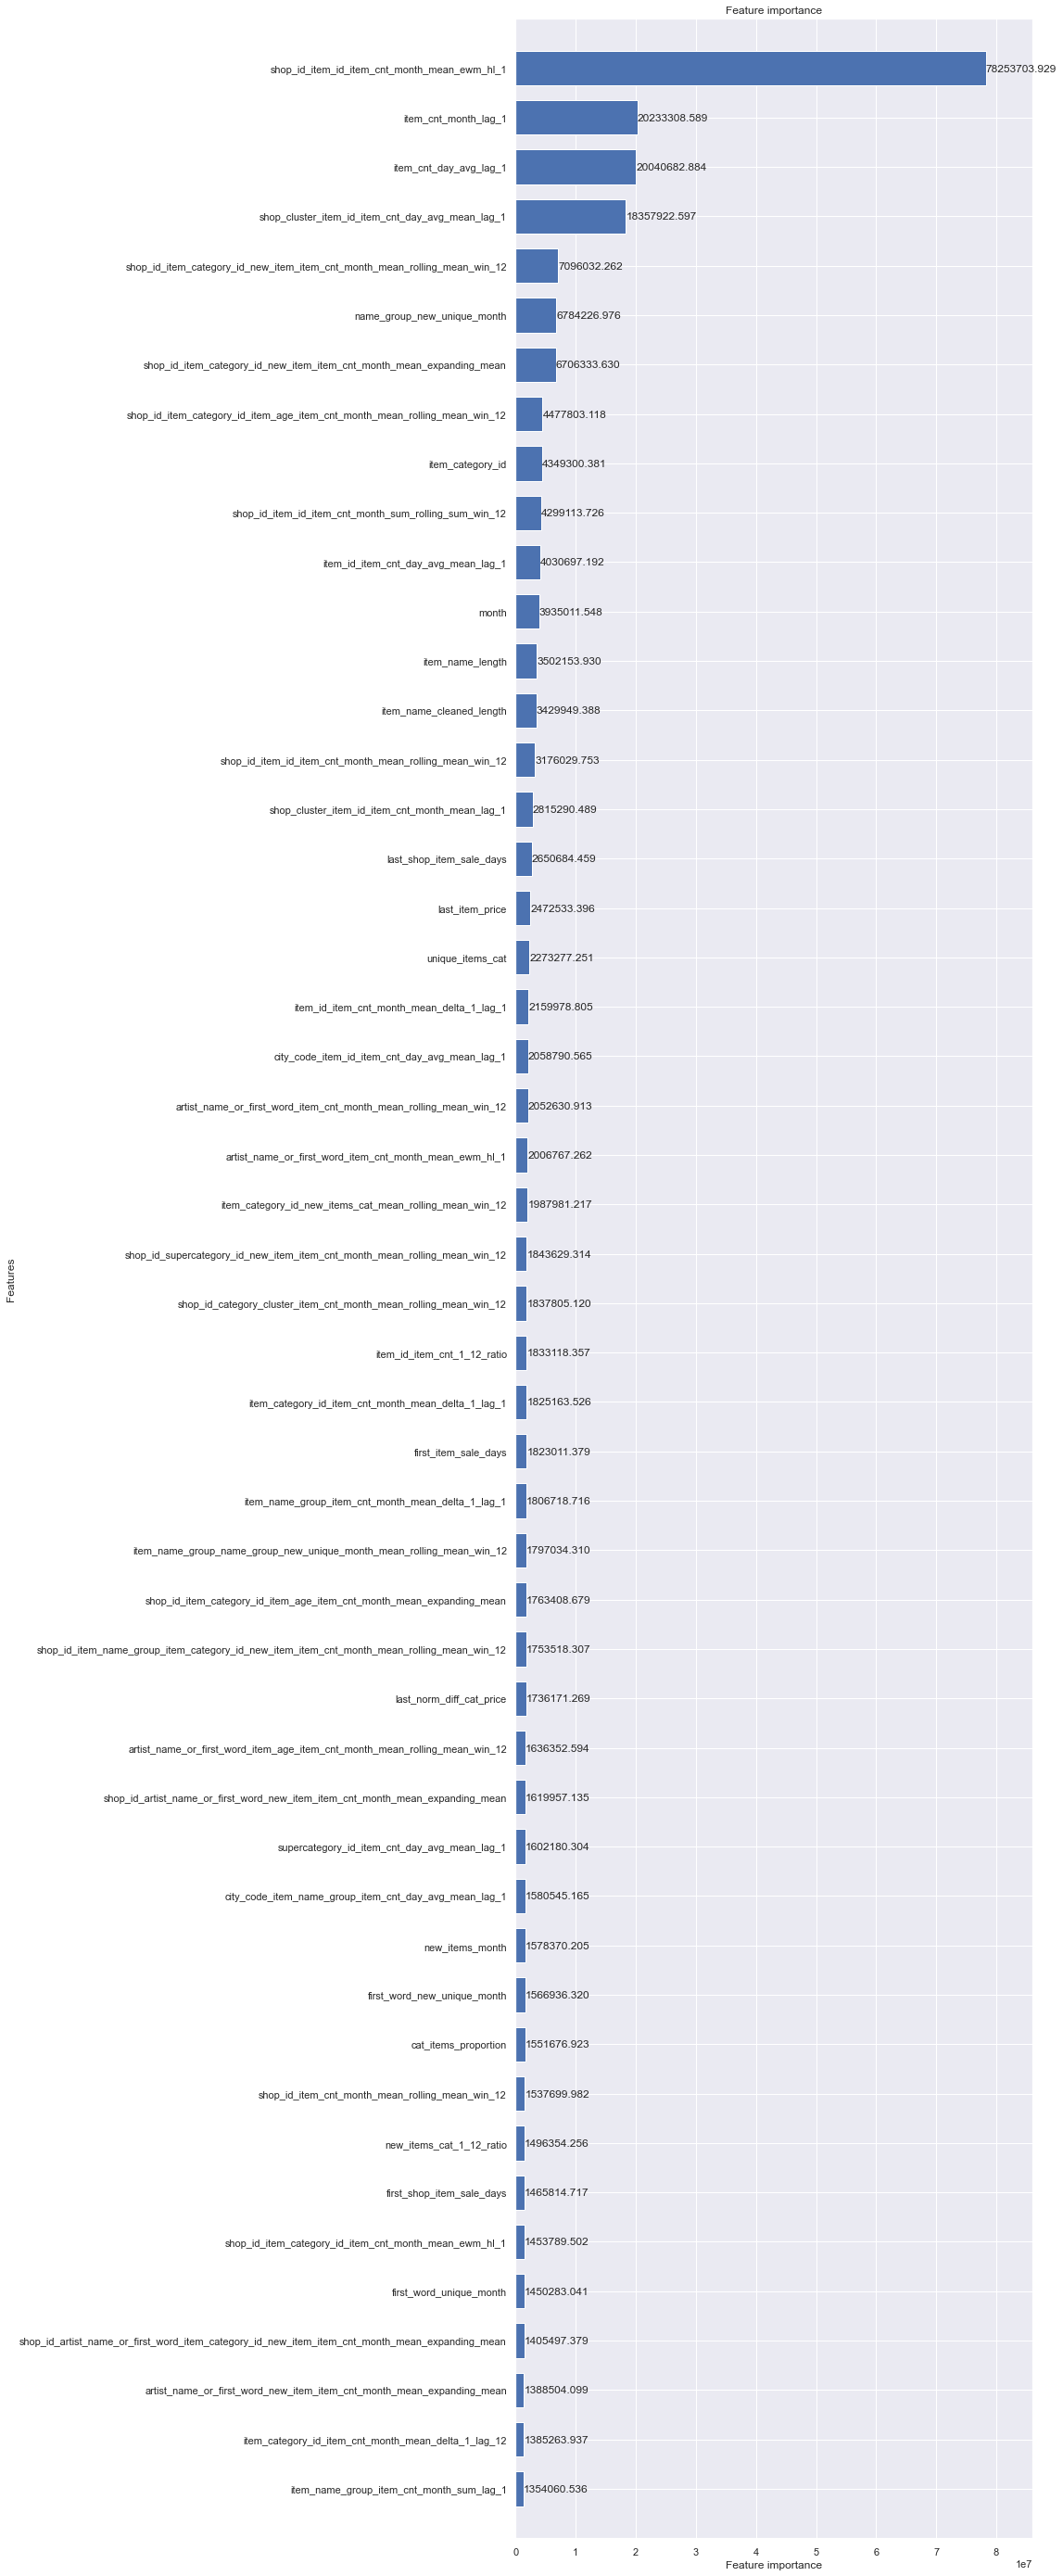

In [ ]:
_ = lgbm.plot_importance(lgbooster, figsize=(10,50), height=0.7, importance_type="gain", max_num_features=50)

Save the trained model

# Create the test submission  
Split the test items from the data matrix and use the trained model to predict the target.

In [ ]:
prediction = lgbooster.predict(X_test)
prediction_lgbooster = prediction

submission = pd.DataFrame({
    "ID": np.arange(prediction.shape[0]), 
    "item_cnt_month": prediction.clip(0, 20)
})
submission.to_csv('submission_lgbm_test.csv', index=False) # public score 0.84669

### Catboost

In [ ]:
%%time
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

model_catboost = CatBoostRegressor(verbose=False, random_seed=566)


model_catboost.fit(X_train,y_train);
prediction_catboost = model_catboost.predict(X_valid)
print(mean_squared_error(y_valid, prediction_catboost, squared=False))

0.7818423924242837
Wall time: 25min 44s


In [ ]:
# prediction = model_catboost.predict(X_test)
# prediction_catboost = prediction

# submission = pd.DataFrame({
#     "ID": np.arange(prediction.shape[0]), 
#     "item_cnt_month": prediction.clip(0, 20)
# })
# submission.to_csv('submission_catboost.csv', index=False)

## Ensemble based on different models

### Meta features

In [ ]:
%%time
models = [lgbooster, model_catboost]

meta_X_train = [model.predict(X_valid) for model in models]

meta_X_train[1] = meta_X_train[1].flatten()

meta_X_train = np.array(meta_X_train).T

meta_X_test = [model.predict(X_test) for model in models]

meta_X_test[1] = meta_X_test[1].flatten()

meta_X_test = np.array(meta_X_test).T

meta_y_train = y_valid

Wall time: 22.6 s


### Simple convex mix

### Two models

In [ ]:
from sklearn.metrics import mean_squared_error

# choose models 
model_index = [0,1]  

alphas_to_try = np.linspace(0, 1, 1001)
rmse_scores = np.empty_like(alphas_to_try)

for ind, alpha in enumerate(alphas_to_try):
    simple_mix_pred = alpha * meta_X_train[:,model_index[0]] + (1 - alpha) * meta_X_train[:,model_index[1]]
    rmse_scores[ind] = mean_squared_error(meta_y_train, simple_mix_pred, squared=False)


best_alpha = alphas_to_try[np.argmin(rmse_scores)]
rmse_train_simple_mix = np.min(rmse_scores) 

print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, rmse_train_simple_mix))

Best alpha: 1.000000; Corresponding rmse score on train: 0.707396


In [ ]:
# remember that meta_X_test is a prediction for a model for X_test
meta_prediction = best_alpha * meta_X_test[:,model_index[0]] + (1 - best_alpha) * meta_X_test[:,model_index[1]]
submission = pd.DataFrame({
    "ID": np.arange(meta_prediction.shape[0]), 
    "item_cnt_month": meta_prediction.clip(0, 20).flatten()
})
submission.to_csv('submission_meta_simple_mix_lgbm_cat2.csv', index=False) # public score 0.84669